# Import dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from operator import itemgetter
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import optim,nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss

from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid

pd.options.plotting.backend = "plotly" #  plotting functions on its DataFrame and Series objects
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# read datasets / rough check 

In [2]:
data = pd.read_csv('../input/sample/sample_labels.csv')
data.head(5) # show the 1~5th data 

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


### check "Patient Gender"

In [3]:
data["Patient Gender"]
# first data : data["Patient Gender"][0]

0       M
1       M
2       M
3       M
4       F
       ..
5601    M
5602    F
5603    F
5604    F
5605    M
Name: Patient Gender, Length: 5606, dtype: object

In [4]:
data["Patient Gender"].value_counts()

M    3134
F    2472
Name: Patient Gender, dtype: int64

In [5]:
data['Patient Gender'].value_counts().plot.bar()

In [6]:
data['Patient Gender'].value_counts().plot.barh()

### check "Patient Age"

In [7]:
data['Patient Age']

0       060Y
1       057Y
2       077Y
3       079Y
4       055Y
        ... 
5601    058Y
5602    061Y
5603    052Y
5604    010Y
5605    024Y
Name: Patient Age, Length: 5606, dtype: object

#### retain "Patient Age" former 3 integer

In [8]:
data['Patient Age'].apply(lambda x : int(x[1:3]))

0       60
1       57
2       77
3       79
4       55
        ..
5601    58
5602    61
5603    52
5604    10
5605    24
Name: Patient Age, Length: 5606, dtype: int64

In [9]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.hist()

In [10]:
data['Patient Age'].apply(lambda x : int(x[1:3])).plot.box()

### check "Finding Labels"

In [11]:
data['Finding Labels']

0       Emphysema|Infiltration|Pleural_Thickening|Pneu...
1                                  Cardiomegaly|Emphysema
2                                              No Finding
3                                             Atelectasis
4                             Cardiomegaly|Edema|Effusion
                              ...                        
5601                                           No Finding
5602                      Cardiomegaly|Effusion|Emphysema
5603                                         Infiltration
5604                                           No Finding
5605                                           No Finding
Name: Finding Labels, Length: 5606, dtype: object

## add datasets column (pathology type & No Findings)

In [12]:
# list all the pathology classification , except "No Finding"
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

# create a new data column :　data[pathology] FOR TOTAL 15 TYPES(COLUMN) INCLUDING 'No Finding'
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
    
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

## check the added list 

In [13]:
data.head(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,...,1,0,1,0,0,0,1,0,0,0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,1
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,...,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,...,0,0,0,0,1,0,0,0,0,0


## delete no-use datasets column ( FROM (2) to (11) )
## only keep datasets column (pathology type & No Findings)

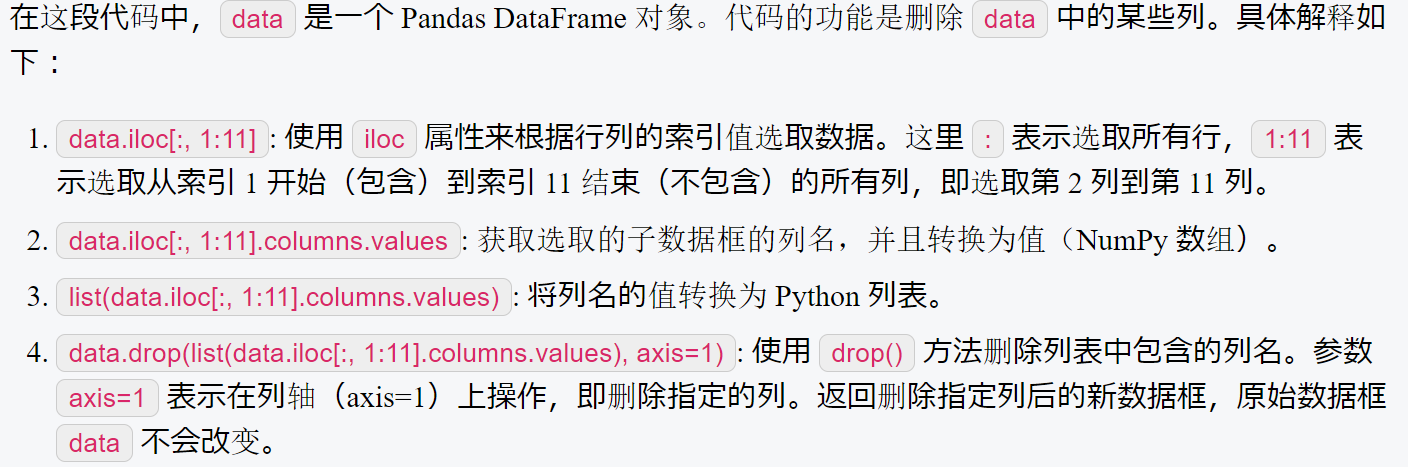

In [14]:
data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1) # iloc : get data from specified index ,axis = 1 is columns

In [15]:
data.iloc[:,1:].sum().plot.barh() # sum : default is column

In [16]:
data.head(5)

,Image Index,Cardiomegaly,Emphysema,Effusion,Hernia,Nodule,Pneumothorax,Atelectasis,Pleural_Thickening,Mass,Edema,Consolidation,Infiltration,Fibrosis,Pneumonia,No Findings
0,00000013_005.png,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0
1,00000013_026.png,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000017_001.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,00000030_001.png,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,00000032_001.png,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0


### delete "No Findings" item and plot again  

In [17]:
data = data.drop(['No Findings'],axis = 1)
data.iloc[:,1:].sum().plot.barh()

## check distribution of each pathology
### show percentages % of each pathology 

In [18]:
data.iloc[:,1:].mean().plot.barh()

# use weighted LOSS to avoid data-inbalance problem

### calculate (positive_frequencies, negative_frequencies) of each pathology 

In [19]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0] # num of rows (culumn sum)

    positive_frequencies = np.sum(labels, axis = 0) / N  # axis = 0 , for culumn sum
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies


### Remind: np.sum() ex.
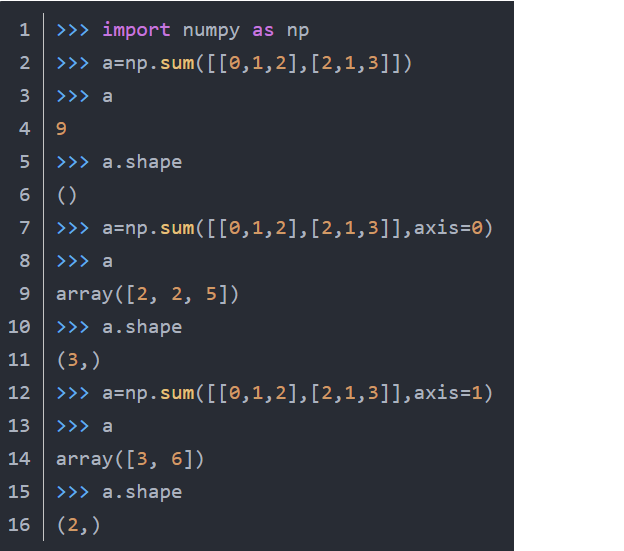

In [20]:
freq_pos,freq_neg = compute_class_freqs(data.iloc[:,1:])
# dim(freq_pos & freq_neg) = 14*1

In [21]:
# merthod 1
"""
def weighted_loss(freq_neg, freq_pos, y_pred, y_true, epsilon=1e-7):
# The epsilon parameter is used to prevent numerical instability when computing the logarithm of values close to 0
    loss = 0.0
    y_pred = y_pred.clamp(min=0, max=1) # prevent y_pred < 0 ,output loss = NAN

    for i in range(len(freq_neg)):
        loss_pos = -1 * torch.mean(freq_neg[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(freq_pos[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    
    return loss
"""

'\ndef weighted_loss(freq_neg, freq_pos, y_pred, y_true, epsilon=1e-7):\n# The epsilon parameter is used to prevent numerical instability when computing the logarithm of values close to 0\n    loss = 0.0\n    y_pred = y_pred.clamp(min=0, max=1) # prevent y_pred < 0 ,output loss = NAN\n\n    for i in range(len(freq_neg)):\n        loss_pos = -1 * torch.mean(freq_neg[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))\n        loss_neg = -1 * torch.mean(freq_pos[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))\n        loss += loss_pos + loss_neg\n    \n    return loss\n'

In [22]:
# merthod 2
'''
def weighted_loss(freq_neg, freq_pos, y_pred, y_true):
    loss = 0.0
    # y_pred = y_pred.clamp(min=0, max=1)
    y_true = torch.argmax(y_true, dim=1)  # 将独热编码转换为类别索引
    y_true = y_true.float() # convert y_true to Float tensor
    
    
    for i in range(len(freq_neg)):
        # Convert numpy float64 to tensor
        freq_neg_tensor = torch.tensor(freq_neg[i], dtype=torch.float)
        freq_pos_tensor = torch.tensor(freq_pos[i], dtype=torch.float)
        
        # Use the tensor as the weight argument in F.cross_entropy
        loss_pos = F.cross_entropy(y_pred[:, i], y_true, weight=freq_neg_tensor)
                
        loss_neg = F.binary_cross_entropy_with_logits(y_pred[:, i], 1-y_true, weight=freq_pos_tensor)
        
        loss += loss_pos + loss_neg
        
        return loss
'''
 

'\ndef weighted_loss(freq_neg, freq_pos, y_pred, y_true):\n    loss = 0.0\n    # y_pred = y_pred.clamp(min=0, max=1)\n    y_true = torch.argmax(y_true, dim=1)  # 将独热编码转换为类别索引\n    y_true = y_true.float() # convert y_true to Float tensor\n    \n    \n    for i in range(len(freq_neg)):\n        # Convert numpy float64 to tensor\n        freq_neg_tensor = torch.tensor(freq_neg[i], dtype=torch.float)\n        freq_pos_tensor = torch.tensor(freq_pos[i], dtype=torch.float)\n        \n        # Use the tensor as the weight argument in F.cross_entropy\n        loss_pos = F.cross_entropy(y_pred[:, i], y_true, weight=freq_neg_tensor)\n                \n        loss_neg = F.binary_cross_entropy_with_logits(y_pred[:, i], 1-y_true, weight=freq_pos_tensor)\n        \n        loss += loss_pos + loss_neg\n        \n        return loss\n'

In [23]:
pos_weights = freq_neg
neg_weights = freq_pos 
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

# check data already balance
print( pos_contribution ,neg_contribution )

[0.02451902 0.02214108 0.10168021 0.00231357 0.05271571 0.0460042
 0.08240572 0.03040929 0.04809357 0.02060582 0.03868873 0.14273966
 0.01475943 0.01093726] [0.02451902 0.02214108 0.10168021 0.00231357 0.05271571 0.0460042
 0.08240572 0.03040929 0.04809357 0.02060582 0.03868873 0.14273966
 0.01475943 0.01093726]


In [24]:
# merthod 3

# 将 positive_frequencies 和 negative_frequencies 转换为张量
#pos_weights = torch.tensor(freq_neg)
#neg_weights = torch.tensor(freq_pos)
#weights = torch.tensor([pos_weights, neg_weights]).to(device)
# 定义损失函数
#criterion = nn.MultiLabelSoftMarginLoss(weight=weights).to(device)

tensor_data = torch.tensor(data.iloc[:, 1:].values) # tensor_data.size() = torch.Size([5606, 14])
num_positives = torch.sum(tensor_data, dim=0) # num_positives.size() = torch.Size([14])
NUM_sample = tensor_data.size(0) # 5606

num_negatives = torch.tensor(NUM_sample).repeat(1,14) - num_positives
pos_weight  = torch.div(num_negatives , num_positives)

criterion = nn.BCEWithLogitsLoss(pos_weight = pos_weight).to(device)


## use "weighted_loss" for the following
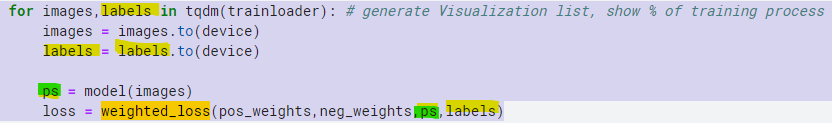

In [25]:
# tag freq_pos to pathology_list
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": freq_pos})
print(df)

                 Class     Label     Value
0         Cardiomegaly  Positive  0.025152
1            Emphysema  Positive  0.022654
2             Effusion  Positive  0.114877
3               Hernia  Positive  0.002319
4               Nodule  Positive  0.055833
5         Pneumothorax  Positive  0.048341
6          Atelectasis  Positive  0.090617
7   Pleural_Thickening  Positive  0.031395
8                 Mass  Positive  0.050660
9                Edema  Positive  0.021049
10       Consolidation  Positive  0.040314
11        Infiltration  Positive  0.172494
12            Fibrosis  Positive  0.014984
13           Pneumonia  Positive  0.011060


In [26]:
# tag freq_neg to pathology_list (append after freq_pos
df = df.append([{"Class": pathology_list[i], "Label": "Negative", "Value": v} for i,v in enumerate(freq_neg)], ignore_index=True)
print(df)

                 Class     Label     Value
0         Cardiomegaly  Positive  0.025152
1            Emphysema  Positive  0.022654
2             Effusion  Positive  0.114877
3               Hernia  Positive  0.002319
4               Nodule  Positive  0.055833
5         Pneumothorax  Positive  0.048341
6          Atelectasis  Positive  0.090617
7   Pleural_Thickening  Positive  0.031395
8                 Mass  Positive  0.050660
9                Edema  Positive  0.021049
10       Consolidation  Positive  0.040314
11        Infiltration  Positive  0.172494
12            Fibrosis  Positive  0.014984
13           Pneumonia  Positive  0.011060
14        Cardiomegaly  Negative  0.974848
15           Emphysema  Negative  0.977346
16            Effusion  Negative  0.885123
17              Hernia  Negative  0.997681
18              Nodule  Negative  0.944167
19        Pneumothorax  Negative  0.951659
20         Atelectasis  Negative  0.909383
21  Pleural_Thickening  Negative  0.968605
22         

/tmp/ipykernel_23/412793751.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



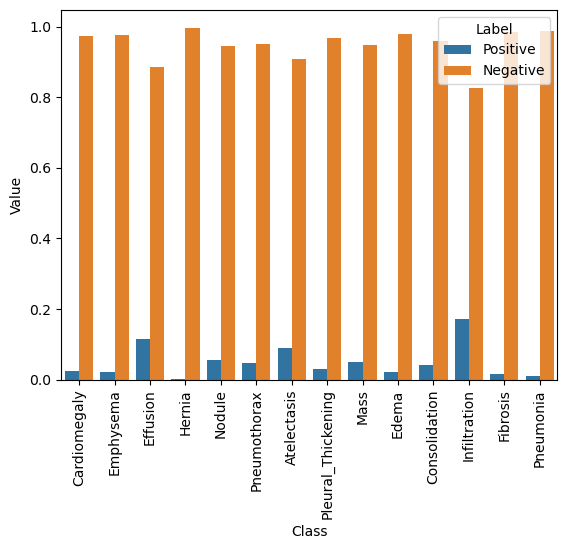

In [27]:
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

/tmp/ipykernel_23/3069971257.py:2: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



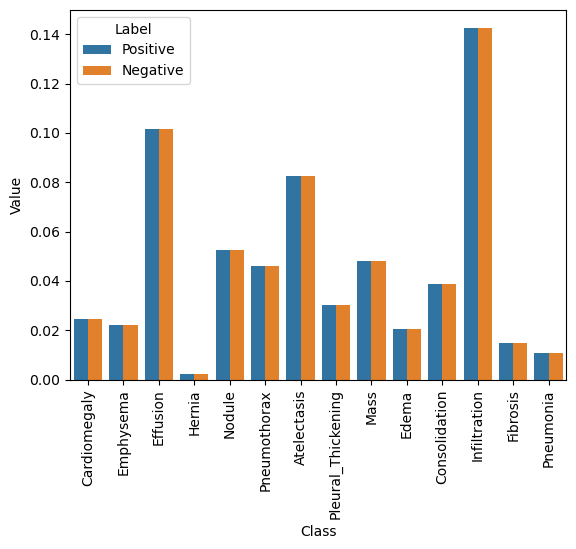

In [28]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": pos_contribution})
df = df.append([{"Class": pathology_list[i], "Label": "Negative", "Value": v} for i,v in enumerate(neg_contribution)], ignore_index=True)

plt.xticks(rotation=90) 
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [29]:
print(data)
num_classes=len(data.iloc[1,1:])
print(num_classes) # 14
type(data)

           Image Index  Cardiomegaly  Emphysema  Effusion  Hernia  Nodule  \
0     00000013_005.png             0          1         0       0       0   
1     00000013_026.png             1          1         0       0       0   
2     00000017_001.png             0          0         0       0       0   
3     00000030_001.png             0          0         0       0       0   
4     00000032_001.png             1          0         1       0       0   
...                ...           ...        ...       ...     ...     ...   
5601  00030712_000.png             0          0         0       0       0   
5602  00030786_005.png             1          1         1       0       0   
5603  00030789_000.png             0          0         0       0       0   
5604  00030792_000.png             0          0         0       0       0   
5605  00030797_000.png             0          0         0       0       0   

      Pneumothorax  Atelectasis  Pleural_Thickening  Mass  Edema  \
0      

pandas.core.frame.DataFrame

# set Dataset & Dataloader and do pre-processing Transform

In [30]:
class NIH_Dataset(Dataset):
    
    # data loading
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 
        #data size
        
    # return the length of our dataset    
    def __len__(self):
        return len(self.data)
    
    # working for indexing(including Dataset Transform)
    # 在__getitem__函數中，通過索引(idx)，先讀取對應的圖像文件，然後使用PIL庫中的Image類別打開並轉換圖像。
    # 接著，讀取對應的標籤(label)，將其轉換為Numpy數組。最後，如果提供了可選的變換(transform)，
    # 則應用該變換並返回圖像和標籤作為一個元組(img, label)。
    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

# Create PyTorch data generators

## pre-processing Transform

In [31]:
data_transform = T.Compose([
    T.RandomResizedCrop(224,scale=(0.8,1.0)), # adjust (size , scale , ratio)
    T.RandomHorizontalFlip(p=0.7), # p : prob.
    
    T.RandomRotation((-10,+10)), # angle from: -10~+10 
    
    T.Resize((224,224)),# ragulization for Model img. input
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], # ragulization for color RGB
                std=[0.229, 0.224, 0.225]),

    T.ColorJitter(brightness=0.1, contrast=0.1),
    T.GaussianBlur(kernel_size=5)

])

In [32]:
trainds = NIH_Dataset(data,
                      img_dir = '../input/sample/sample/sample/images/',
                      transform = data_transform)

## reverse pre-processing(deprocessing) for showing data 

### regulization : (origin data - mean,which is 0)/std,which is sigma

In [33]:
# back to origin data , purpose : easy to look!!
def deprocess(img):
    img = img.permute(1,2,0) # transform img dim from (C, H, W) to (H, W, C)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406]) 
    # Anti-Normalize: data * std + mean , para. same as: T.Normalize 
    return img

## show first(0th) data

In [34]:
img, label = trainds[0]
class_labels = list(np.where(label==1)[0])

In [35]:
print(img)
print(label)
print(class_labels)
AA=np.where(label==1)
print(AA[0])

tensor([[[0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         ...,
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029]],

        [[0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         ...,
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029]],

        [[0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.0029],
         [0.0029, 0.0029, 0.0029,  ..., 0.0029, 0.0029, 0.

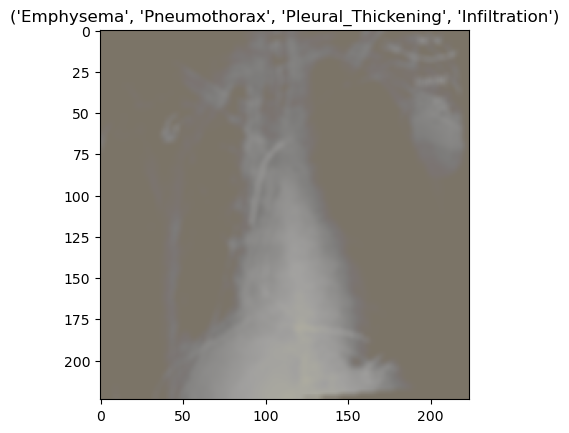

In [36]:
plt.imshow(deprocess(img))
plt.title(itemgetter(*class_labels)(pathology_list));# (*class_labels) = [ 1  5  7 11] , itemgetter will return tuple format

# train the model

> # distribute Dataset and generate Dataloader

## reminder "trainds"
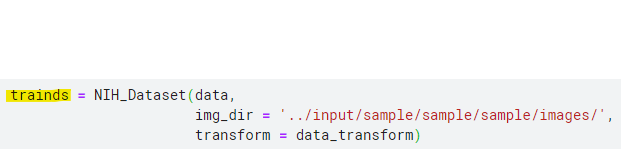

In [37]:
trainset, validset, testset = random_split(trainds, [5000,303,303])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 5000
Length of testset : 303
Length of validset : 303


In [38]:
NUM_batch_size = 32

In [39]:
trainloader = DataLoader(trainset,
                         batch_size = NUM_batch_size,
                         shuffle = True)
# shuffle = True 表示在每個 epoch（即一次完整的訓練過程）開始前將資料隨機打散。
# 這樣可以在每個 epoch 中隨機選取不同的樣本，增加模型的泛化能力

validloader = DataLoader(validset,
                         batch_size = NUM_batch_size,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = NUM_batch_size,
                        shuffle = True)

## define pretrain model


### 預訓練的RESNET18模型上新增 Group Normalization 
### 將預訓練的RESNET18模型定義為一個類別，並在其初始化方法中新增Group Normalization層
### 並將其應用於ResNet18模型的最後一層全連接層之前。在此我們選擇使用32個groups。

In [40]:
class ResNet18(nn.Module):
    def __init__(self, num_classes = num_classes):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(self.num_ftrs, num_classes)
        self.group_norm = nn.GroupNorm(num_groups=8, num_channels=self.num_ftrs)
        
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.group_norm(x)
        x = self.resnet.fc(x)
        return x

In [41]:
# use model "resnet18"
model = ResNet18(num_classes=num_classes)
#print(model)
#model.load_state_dict(torch.load('../input/pretrained-model-weights-pytorch/resnet18-5c106cde.pth'))

"""
# change the model to "resnet50"
model = models.resnet50()
#print(model)
model.load_state_dict(torch.load('../input/pretrained-model-weights-pytorch/resnet50-19c8e357.pth'))
"""
model.to(device) # show each model layer 


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


ResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

## devise model output layer framework

change 

to
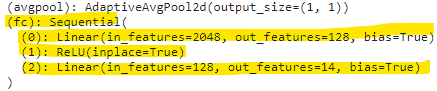

## using "resnet18" & "resnet50" as fixed feature extractor
## Here, we need to freeze all the network except the final layer. Set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [42]:
"""
for param in model.parameters():
    param.requires_grad = True
"""

# for model "resnet18"
"""
model.fc = nn.Sequential(
    nn.Linear(512, 14), # change nn.linear(512,1000) to  nn.linear(512, 14) 
    nn.Sigmoid() # add sigmoid
)
"""
# ###################################################################
"""
# for model "resnet50"
# modify the last fc,transfer to few layers(2048*1000＞＞＞２０４８＊２)
#model.fc = nn.Linear(2048, 14)

# 在全连接层之前加入Dropout层
model.fc = nn.Sequential(
               nn.Dropout(0.2), # 添加Dropout层，概率为0.5
               nn.Linear(in_features=2048, out_features=14, bias=True)
           ) 
"""
#(fc): Sequential(
#    (0): Linear(in_features=2048, out_features=128, bias=True)
#    (1): ReLU(inplace=True)
#    (2): Linear(in_features=128, out_features=14, bias=True)  

#model.to(device)

'\n# for model "resnet50"\n# modify the last fc,transfer to few layers(2048*1000＞＞＞２０４８＊２)\n#model.fc = nn.Linear(2048, 14)\n\n# 在全连接层之前加入Dropout层\nmodel.fc = nn.Sequential(\n               nn.Dropout(0.2), # 添加Dropout层，概率为0.5\n               nn.Linear(in_features=2048, out_features=14, bias=True)\n           ) \n'

## train model

In [43]:
#optimizer = optim.Adam(model.parameters(),lr = 0.0001)
optimizer = optim.Adam(model.parameters(),lr = 0.00001)

schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.05,patience = 4)
#schedular = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

NUM_epochs = 30

epochs = NUM_epochs
valid_loss_min = np.Inf # initial value of "valid_loss_min" = infinity

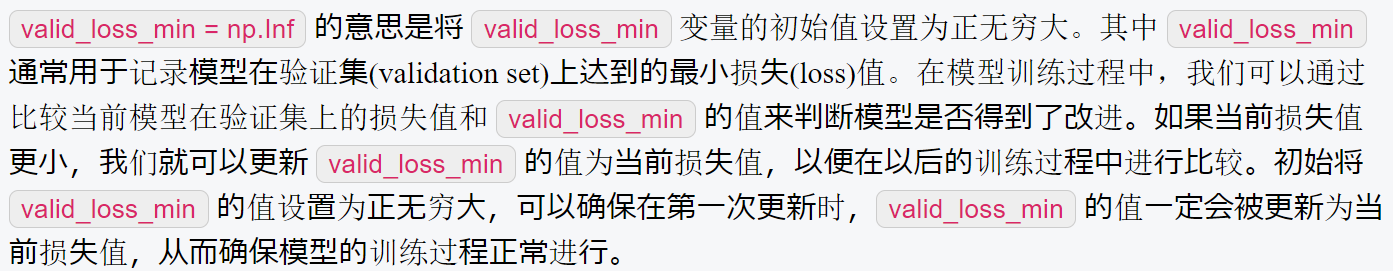
# 應用於下一段程式碼
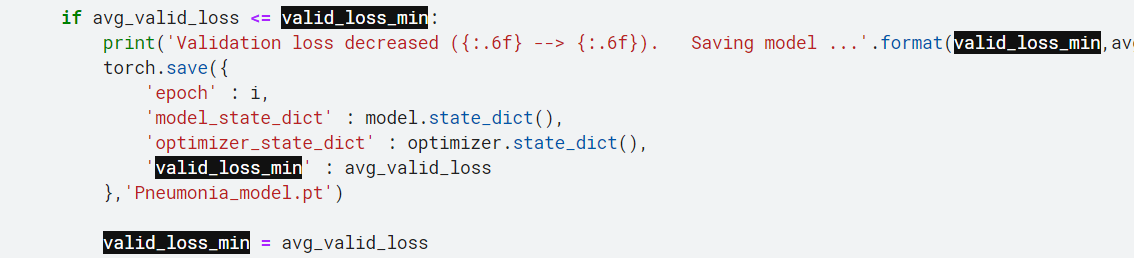

In [44]:
for i in range(epochs):

    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0 

# ###############################################################################################
# training part

    model.train(True) # activate "dropout", model.train(True) --- deactivated
    
    for images,labels in tqdm(trainloader): # generate Visualization list, show % of training process
        images = images.to(device)
        #labels = labels.to(device) # Size([32, 14]) 
        labels = labels.float().to(device)
        
        #print(labels)
        ps = model(images) # Size([32, 14]) (batch_size, num_classes)  dtype = float 32
        
        # 假设 ps 的形状为 (batch_size, num_classes)，labels 的形状为 (batch_size,)
        # 将 labels 转换为 one-hot 张量
        #labels_one_hot = F.one_hot(labels, num_classes=num_classes).float() #Size([32, 14, 14]) (batch_size, num_labels, num_classes)
        #print(labels_one_hot)
        # 假设 ps 的形状为 (batch_size, num_classes)，labels 的形状为 (batch_size, num_labels, num_classes)
        # 将 labels 转换为 one-hot 张量，并对第二个维度取平均值
        #labels_one_hot_avg = torch.mean(labels_one_hot, dim=1) # Size([32, 14]) (batch_size, num_classes) dtype = float 32
        #print(labels_one_hot_avg)
        #loss = weighted_loss(pos_weights,neg_weights,ps,labels)
        #AA=ps.dtype    
        #print(ps)
        #AA=labels.dtype
        #print(labels)
        
        optimizer.zero_grad()
        # 计算损失
        loss = criterion(ps, labels)
        #loss = criterion(ps, labels)
        #print(loss)
        
        loss.backward()
        
        # 加入梯度裁剪程式碼
        clip_value = 0.1 #  設定梯度裁剪的閾值，即最大梯度值，一般來說可以設定為1.0或者5.0，對於簡單資料集與不深的模型，可用0.1、0.5做更嚴格規範
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        
        # ###################
        # 加入正則化: 控制模型的复杂度，避免模型过拟合训练集而泛化能力较差
        # 加入L2 權重 正則化
        l2_lambda = 0.0001
        l2_loss = 0.0
        for param in model.parameters():         
            l2_loss += torch.norm(param, 2) ** 2
            loss = loss + l2_lambda * l2_loss
        # ###################    
        """　
        # 加入L1 權重 正則化 (*注意，L1正則化通常會導致模型參數稀疏化，因此L1正則化常用於特徵選擇或壓縮。)
        l1_lambda = 0.0001　
        l1_loss = 0.0
        for param in model.parameters():
            l1_loss += torch.norm(param, 1)
            loss = loss + l1_lambda * l1_loss
        # ###################
        """
        
        # ###################
        optimizer.step()
        
        # print statistics
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(trainloader)
       
# ###############################################################################################
# Validation part

    model.eval() # use evaluation mode
    with torch.no_grad(): # no checking grad. to avoid accumulate (dev. grad. calculate) 
        for images,labels in tqdm(validloader):
            images = images.to(device)
            #labels = labels.to(device)
            labels = labels.float().to(device)
            
            ps = model(images)
            
            loss = criterion(ps, labels)
            #loss = weighted_loss(pos_weights,neg_weights,ps,labels)
            
            valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(validloader)
        len_validloader = len(validloader)
        #print("valid_loss:",valid_loss)
        #print("len_validloader",len_validloader)
    schedular.step(avg_valid_loss)

    if avg_valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
        torch.save({
            'epoch' : i,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'valid_loss_min' : avg_valid_loss
        },'Pneumonia_model.pt')

        valid_loss_min = avg_valid_loss

    print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))

100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


Validation loss decreased (inf --> 1.253603).   Saving model ...
Epoch : 1 Train Loss : 16.388549 
Epoch : 1 Valid Loss : 1.253603 


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Validation loss decreased (1.253603 --> 1.226604).   Saving model ...
Epoch : 2 Train Loss : 16.299474 
Epoch : 2 Valid Loss : 1.226604 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Validation loss decreased (1.226604 --> 1.200176).   Saving model ...
Epoch : 3 Train Loss : 16.246296 
Epoch : 3 Valid Loss : 1.200176 


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch : 4 Train Loss : 16.193720 
Epoch : 4 Valid Loss : 1.207474 


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch : 5 Train Loss : 16.166009 
Epoch : 5 Valid Loss : 1.215745 


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Validation loss decreased (1.200176 --> 1.183392).   Saving model ...
Epoch : 6 Train Loss : 16.128644 
Epoch : 6 Valid Loss : 1.183392 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Validation loss decreased (1.183392 --> 1.162099).   Saving model ...
Epoch : 7 Train Loss : 16.100260 
Epoch : 7 Valid Loss : 1.162099 


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Epoch : 8 Train Loss : 16.083688 
Epoch : 8 Valid Loss : 1.196631 


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch : 9 Train Loss : 16.050986 
Epoch : 9 Valid Loss : 1.200945 


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch : 10 Train Loss : 16.041177 
Epoch : 10 Valid Loss : 1.206453 


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch : 11 Train Loss : 16.018156 
Epoch : 11 Valid Loss : 1.185637 


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch : 12 Train Loss : 16.000076 
Epoch : 12 Valid Loss : 1.214396 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch : 13 Train Loss : 15.979533 
Epoch : 13 Valid Loss : 1.164875 


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


Epoch : 14 Train Loss : 15.969354 
Epoch : 14 Valid Loss : 1.236164 


100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


Epoch : 15 Train Loss : 15.972572 
Epoch : 15 Valid Loss : 1.199932 


100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Epoch : 16 Train Loss : 15.958631 
Epoch : 16 Valid Loss : 1.207128 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch : 17 Train Loss : 15.967075 
Epoch : 17 Valid Loss : 1.179149 


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Validation loss decreased (1.162099 --> 1.153505).   Saving model ...
Epoch : 18 Train Loss : 15.966757 
Epoch : 18 Valid Loss : 1.153505 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch : 19 Train Loss : 15.968114 
Epoch : 19 Valid Loss : 1.225980 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


Epoch : 20 Train Loss : 15.968193 
Epoch : 20 Valid Loss : 1.171962 


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch : 21 Train Loss : 15.960339 
Epoch : 21 Valid Loss : 1.213061 


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch : 22 Train Loss : 15.968051 
Epoch : 22 Valid Loss : 1.196999 


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch : 23 Train Loss : 15.959555 
Epoch : 23 Valid Loss : 1.204935 


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch : 24 Train Loss : 15.970448 
Epoch : 24 Valid Loss : 1.171655 


100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Validation loss decreased (1.153505 --> 1.140730).   Saving model ...
Epoch : 25 Train Loss : 15.971174 
Epoch : 25 Valid Loss : 1.140730 


100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


Epoch : 26 Train Loss : 15.962781 
Epoch : 26 Valid Loss : 1.177934 


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch : 27 Train Loss : 15.967515 
Epoch : 27 Valid Loss : 1.187337 


100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


Epoch : 28 Train Loss : 15.964945 
Epoch : 28 Valid Loss : 1.171650 


100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch : 29 Train Loss : 15.965628 
Epoch : 29 Valid Loss : 1.228355 


100%|██████████| 10/10 [00:07<00:00,  1.26it/s]

Epoch : 30 Train Loss : 15.969865 
Epoch : 30 Valid Loss : 1.186286 


# accuracy of each pathology classification

In [45]:
def class_accuracy(dataloader, model):

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0

    with torch.no_grad():
        for images,labels in dataloader:
            ps = model(images.to(device))
            labels = labels.to(device)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df 

In [46]:
print("Train Dataset Accuracy Report")
acc_list = class_accuracy(trainloader, model)
get_acc_data(pathology_list,acc_list)

Train Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,80.30
1,Emphysema,82.38
2,Effusion,79.46
3,Hernia,90.80
4,Nodule,81.80
5,Pneumothorax,80.96
6,Atelectasis,79.30
7,Pleural_Thickening,79.46
8,Mass,83.16
9,Edema,83.78


In [47]:
print("Test Dataset Accuracy Report")
acc_list = class_accuracy(testloader, model)
get_acc_data(pathology_list,acc_list)

Test Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,79.867987
1,Emphysema,81.188119
2,Effusion,75.577558
3,Hernia,90.759076
4,Nodule,82.508251
5,Pneumothorax,77.557756
6,Atelectasis,77.557756
7,Pleural_Thickening,77.227723
8,Mass,81.188119
9,Edema,82.178218


In [48]:
print("Valid Dataset Accuracy Report")
acc_list = class_accuracy(validloader, model)
get_acc_data(pathology_list,acc_list)

Valid Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,78.877888
1,Emphysema,83.168317
2,Effusion,78.547855
3,Hernia,90.099010
4,Nodule,77.887789
5,Pneumothorax,76.897690
6,Atelectasis,72.607261
7,Pleural_Thickening,75.577558
8,Mass,82.178218
9,Edema,84.818482


# plot the result

In [49]:
def view_classify(img, ps, label):

    class_name = pathology_list
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    img = deprocess(img)
    class_labels = list(np.where(label==1)[0])

    if not class_labels :
        title = 'No Findings'
    else : 
        title = itemgetter(*class_labels)(class_name)


    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(title))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

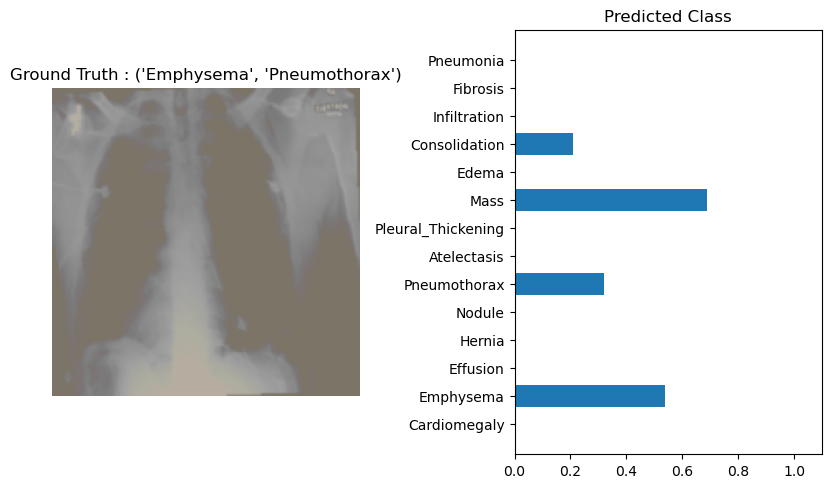

In [50]:
image,label = testset[123]

ps = model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

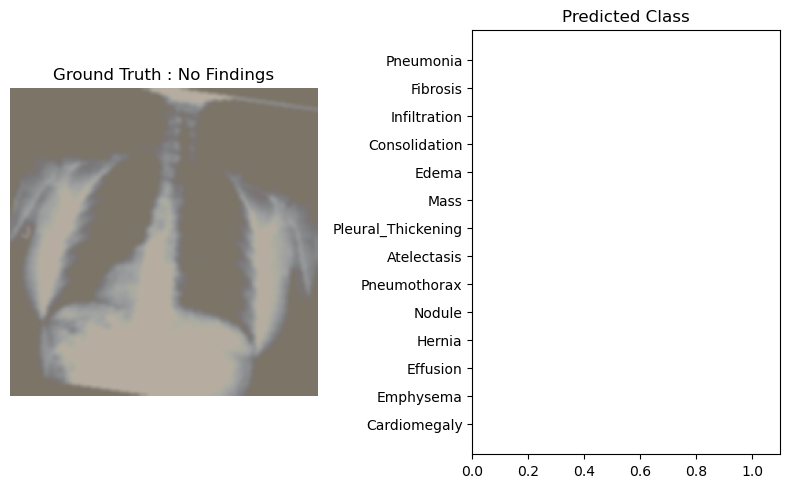

In [51]:
image,label = trainset[999]

ps = model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

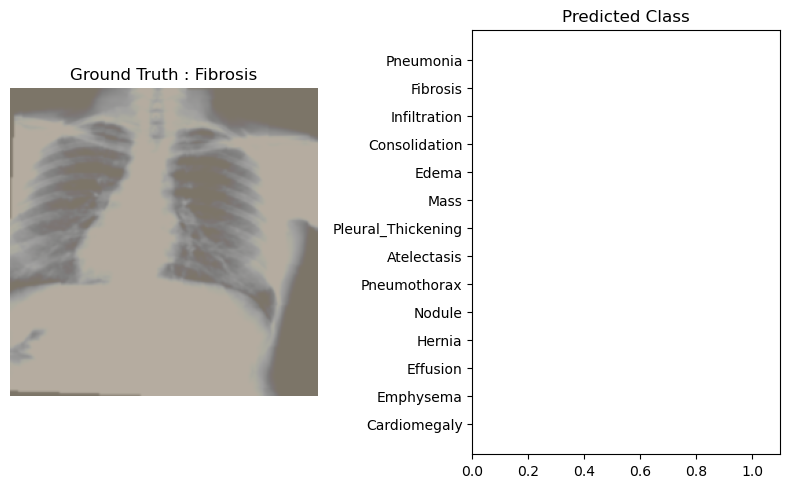

In [52]:
image,label = validset[234]

ps = model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)